In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Constants:
    R = 8.314472                   # J/mol.K
    T0K = 273.15                   # K

In [3]:
class Conditions:
    p0 = 1.01325e5                 # Pa
    T0 = 0 + Constants.T0K         # K

In [4]:
class Water:
    M = 18.0153e-3                 # Kg/mol
    Tvap = 99.94 + Constants.T0K   # K
    cp = 1.826e3                   # J/kg.K
    Hv = 40.662e3                  # J/mol
    lv = Hv/M                      # J/Kg

In [5]:
class Air:
    M = 28.6953e-3                 # Kg/mol
    cp = 1.006e3                   # J/Kg.K

In [23]:
class Mix:
    
    C = Constants
    CSTP = Conditions
    gas = Air
    liquid = Water
    
    Mr = liquid.M/gas.M
    
    def psat(T):
        return Mix.CSTP.p0*np.exp(-Mix.liquid.Hv/Mix.C.R*(1/T - 1/Mix.liquid.Tvap))
    
    def pw(T, phi=1.):
        return phi*Mix.psat(T)
    
    def pisov(T, v):
        return Mix.CSTP.p0 - (Mix.C.R*T)/(Mix.gas.M*v)
    
    def pisoh(T, h):
        dT = (T - Mix.CSTP.T0)
        return Mix.CSTP.p0*(h - Mix.gas.cp*dT)/\
                ((h + Mix.Mr*Mix.liquid.lv) + (Mix.Mr*Mix.liquid.cp - Mix.gas.cp)*dT)

    def Tmin_score(f, k):
        def inner(T):
            return Mix.psat(T) - f(T, k)
        return inner
    
    def Tmin(f, k):
        return optimize.root(Mix.Tmin_score(f, k), 0.1, tol=1e-4)
    
    def Tmax(f, k):
        return optimize.root(lambda T: f(T, k), 0.1, tol=1e-4)
    
    def Boundaries(f, konsts, Tmin, Tmax):
        n = konsts.size
        Ts = np.full((n, 2), np.nan)
        for i, k in enumerate(konsts):
            rmin = Mix.Tmin(f, k)
            if rmin.success:
                Ts[i,0] = max(rmin.x[0], Tmin)
            rmax = Mix.Tmax(f, k)
            if rmax.success:
                Ts[i,1] = min(rmax.x[0], Tmax)
        return Ts
    
    def Trange():
         return {'Tmin': -10. + Constants.T0K, 'Tmax': 35. + Constants.T0K}
    
    def compute(f, konsts, Tmin, Tmax, ns=101):
        nk = konsts.size
        T = np.full((ns, nk), np.nan)
        xT = np.full((ns, nk), np.nan)
        Ts = Mix.Boundaries(f, konsts, Tmin, Tmax)
        for i, k in enumerate(konsts):
            T[:,i] = np.linspace(*Ts[i,:], ns)
            xT[:,i] = f(T[:,i], k)
        return T, xT
    
    def plot(Tmin=Constants.T0K, Tmax=35.+Constants.T0K, ns=101):
        
        # Curves:
        kOy = 1000.
        T = np.linspace(Tmin, Tmax, ns)
        psat = Mix.psat(T)/kOy
        pphi = np.array([Mix.pw(T, phi=phi)/kOy for phi in np.arange(0.1, 0.91, 0.1)]).T
        Tv, pv = Mix.compute(Mix.pisov, np.arange(0.75, 0.96, 0.01), Tmin, Tmax, ns)
        Th, ph = Mix.compute(Mix.pisoh, np.arange(-1e4, 17.1e4, 1e4), Tmin, Tmax, ns)
        
        print(Tv)
        print(pv)
        
        # Figure:
        fig, axe = plt.subplots()
        axe.plot(T, psat, label=r"Saturation: $p_\mathrm{sat}(T)$", color='black', linewidth=2.5)
        axe.plot(T, pphi, color='black', linewidth=0.5)
        axe.plot(Tv, pv/kOy, color='blue', linewidth=0.5)
        axe.plot(Th, ph/kOy, color='purple', linewidth=0.5)
        axe.set_title(r"{} Psychrometric Chart: $p_0 = {:.3f}$ $[\mathrm{{kPa}}]$".format(
            Mix.liquid.__name__, Mix.CSTP.p0/1000.))
        axe.set_xlabel(r"Temperature, $T$ $[\mathrm{K}]$")
        axe.set_ylabel(r"Partial Pressure, $p_w$ $[\mathrm{kPa}]$")
        axe.legend(bbox_to_anchor=(1,1), loc='upper left')
        axe.set_xlim(T[[0,-1]])
        axe.set_ylim([0, 4])
        axe.grid()
        return axe

[[273.15       273.15       273.15       ... 306.43256281 308.0586387
  309.60878134]
 [273.04123233 273.0762021  273.11117186 ... 306.44973718 308.05955232
  309.59419353]
 [272.93246467 273.00240419 273.07234372 ... 306.46691155 308.06046593
  309.57960571]
 ...
 [262.4907686  265.91780552 269.34484243 ... 308.11565126 308.14817277
  308.17917563]
 [262.38200094 265.84400762 269.3060143  ... 308.13282563 308.14908639
  308.16458781]
 [262.27323327 265.77020971 269.26718616 ... 308.15       308.15
  308.15      ]]
[[-4202.06200667 -2813.5480329  -1461.09935715 ...  5853.03299524
   6367.46244084  6894.22146242]
 [-4160.0413866  -2785.41255257 -1446.48836357 ...  5847.68215702
   6367.18082421  6898.67075023]
 [-4118.02076654 -2757.27707224 -1431.87737    ...  5842.3313188
   6366.89920758  6903.12003804]
 ...
 [  -84.04124013   -56.27096066   -29.22198714 ...  5328.6508496
   6339.86401096  7330.25166758]
 [  -42.02062007   -28.13548033   -14.61099357 ...  5323.30001138
   6339.582394

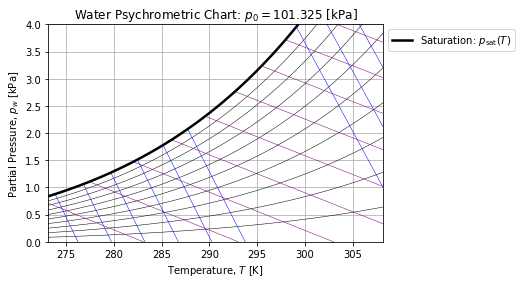

In [24]:
axe = Mix.plot()

In [25]:
df = pd.read_csv('Psychro_data.csv', header=[0,1], index_col=0, parse_dates=[0])
df.iloc[:6,:6]

channel             battery_status                                          \
device_name              node-T001 node-T002 node-T003 node-T004 node-T005   
timestamp                                                                    
2019-10-26 18:15:00            3.0       3.0       3.0       3.0       NaN   
2019-10-26 18:30:00            3.0       3.0       3.0       3.0       NaN   
2019-10-26 18:45:00            3.0       3.0       3.0       3.0       NaN   
2019-10-26 19:00:00            3.0       3.0       3.0       3.0       NaN   
2019-10-26 19:15:00            3.0       3.0       3.0       3.0       NaN   
2019-10-26 19:30:00            3.0       3.0       3.0       3.0       NaN   

channel             battery_voltage  
device_name               node-T001  
timestamp                            
2019-10-26 18:15:00        3.108000  
2019-10-26 18:30:00        3.106667  
2019-10-26 18:45:00        3.106000  
2019-10-26 19:00:00        3.106000  
2019-10-26 19:15:00        3.105333  
2019-10-26 19:30:00        3.104000

In [26]:
T = df['node_temperature'] + Constants.T0K
T.columns = pd.MultiIndex.from_product([['T'], T.columns])
T.head()

T                                            
                      node-T001   node-T002 node-T003   node-T004 node-T005
timestamp                                                                  
2019-10-26 18:15:00  291.265000  293.345000    293.20  294.885000       NaN
2019-10-26 18:30:00  291.226667  293.303333    293.16  294.863333       NaN
2019-10-26 18:45:00  291.203333  293.263333    293.13  294.840000       NaN
2019-10-26 19:00:00  291.290000  293.240000    293.10  294.813333       NaN
2019-10-26 19:15:00  291.206667  293.200000    293.07  294.786667       NaN

In [10]:
RH = df['node_humidity']/100.
RH.columns = pd.MultiIndex.from_product([['RH'], RH.columns])
RH.head()

RH                                        
                    node-T001 node-T002 node-T003 node-T004 node-T005
timestamp                                                            
2019-10-26 18:15:00  0.599500  0.741500  0.736500  0.691000       NaN
2019-10-26 18:30:00  0.601333  0.739333  0.734667  0.692000       NaN
2019-10-26 18:45:00  0.606667  0.739333  0.734000  0.691333       NaN
2019-10-26 19:00:00  0.607000  0.738333  0.733000  0.691333       NaN
2019-10-26 19:15:00  0.609000  0.736333  0.731667  0.692000       NaN

In [11]:
pw = pd.DataFrame(Mix.pw(T.values , phi=RH.values)/1000., columns = T['T'].columns, index = T.index)
pw.columns = pd.MultiIndex.from_product([['pw'], pw.columns])
pw.head()

pw                                        
                    node-T001 node-T002 node-T003 node-T004 node-T005
timestamp                                                            
2019-10-26 18:15:00  1.528387  2.129416  2.097691  2.164907       NaN
2019-10-26 18:30:00  1.529676  2.118171  2.087712  2.165399       NaN
2019-10-26 18:45:00  1.541168  2.113359  2.082260  2.160476       NaN
2019-10-26 19:00:00  1.549739  2.107702  2.075875  2.157237       NaN
2019-10-26 19:15:00  1.547393  2.097216  2.068563  2.156079       NaN

[[273.15                nan 273.15       ... 308.84293184 309.60876792
  310.35666908]
 [273.04123233          nan 273.0762021  ... 308.83600252 309.59418024
  310.33460239]
 [272.93246467          nan 273.00240419 ... 308.8290732  309.57959256
  310.31253569]
 ...
 [262.4907686           nan 265.91780552 ... 308.16385864 308.17917536
  308.19413338]
 [262.38200094          nan 265.84400762 ... 308.15692932 308.16458768
  308.17206669]
 [262.27323327          nan 265.77020971 ... 308.15       308.15
  308.15      ]]
[[-4202.06200667            nan -2813.5480329  ...  6629.40795601
   6894.22555604  7161.71171475]
 [-4160.0413866             nan -2785.41255257 ...  6631.5325826
   6898.67480291  7168.40682516]
 [-4118.02076654            nan -2757.27707224 ...  6633.65720919
   6903.12404979  7175.10193556]
 ...
 [  -84.04124013            nan   -56.27096066 ...  6837.62136168
   7330.25174946  7817.83253421]
 [  -42.02062007            nan   -28.13548033 ...  6839.74598827
   7334.7009

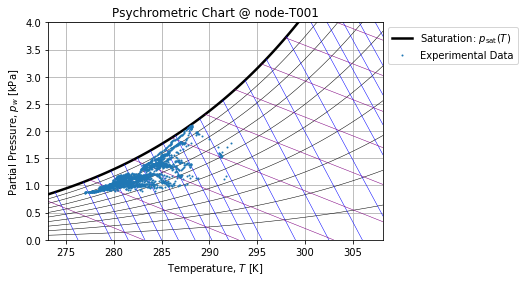

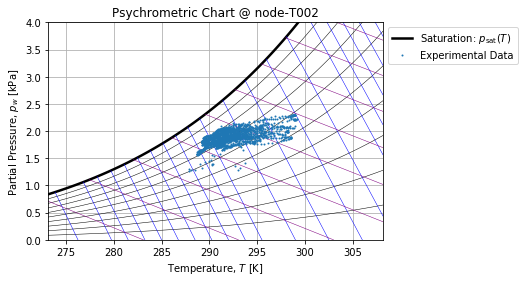

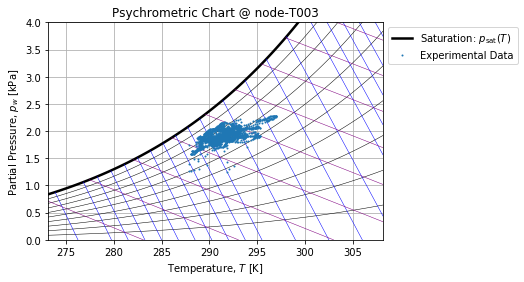

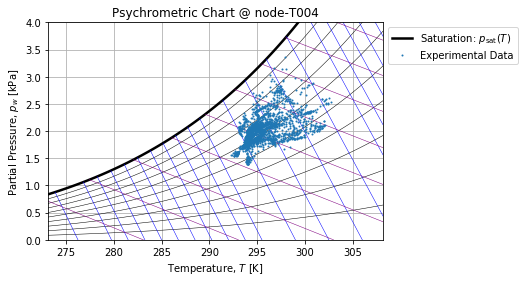

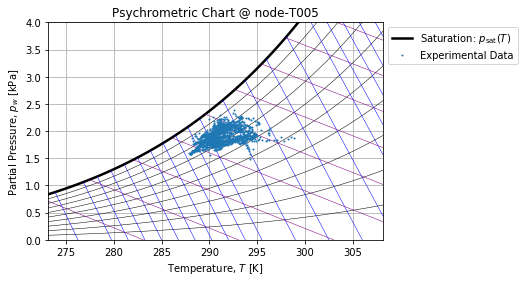

In [12]:
for k in T.columns.levels[-1]:
    idx = pd.IndexSlice[:,k]
    axe = Mix.plot()
    #axe.set_title(r"{} @ {}".format(axe.get_title(), k))
    axe.set_title(r"Psychrometric Chart @ {}".format(k))
    axe.plot(T.loc[:,idx].values.ravel(), pw.loc[:,idx].values.ravel(), '.', markersize=2, label='Experimental Data')
    axe.legend(bbox_to_anchor=(1,1), loc='upper left')